<a href="https://colab.research.google.com/github/massimocipressi/MLPNS_MCipressi/blob/main/MPLNS_27_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["image.interpolation"] = "nearest" #togliamo l'interpolazione automatica
plt.rcParams["image.cmap"] = "gist_gray" #useremo bianco e nero

In [4]:
cd /content/drive/MyDrive/MPLNS2023

/content/drive/MyDrive/MPLNS2023


In [5]:
ls

HiggsBoson/     spm/                          wine.data.1
KaggleTitanic/  spm-20210427T111354Z-001.zip  wine.names
model.png       wine.data                     wine.names.1


In [6]:
!unzip spm-20210427T111354Z-001.zip

Archive:  spm-20210427T111354Z-001.zip
replace spm/spm_struct_pos.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/spm_struct_neg.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/test_good_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/train_good_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/test_bad_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/train_bad_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
data=np.load("spm/train_good_all.npy")

In [8]:
data.shape #sono 1302 immagini 64x64

(1302, 64, 64)

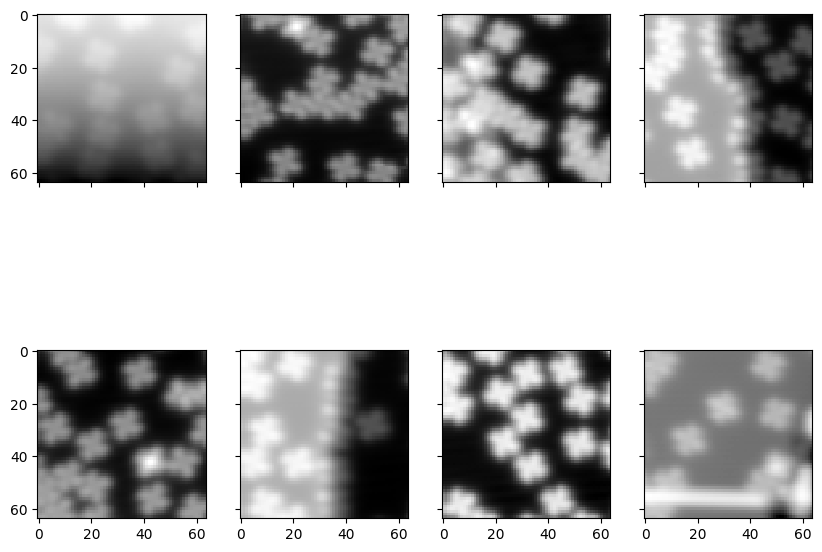

In [9]:
fig,ax=plt.subplots(2,4,sharex=True,sharey=True) #creo gli assi solo all'esterno
for ii in range(8):
  ax[ii//4,ii%4].imshow(data[ii]) #questo serve a selezionare gli indici giusti

In [10]:
#dobbiamo riconoscere queste croci nelle immagini
#per trainare la CNN, cioé trainare le sue weight map (le sue forme), 
#devo però avere dei casi di test in cui so le posizioni giuste

(array([ 254226.,  957465., 1143646., 1050540.,  825288.,  338534.,
         391059.,  151471.,  179803.,   40960.]),
 array([-1.07775726e-07, -9.55749615e-08, -8.33741970e-08, -7.11734324e-08,
        -5.89726678e-08, -4.67719032e-08, -3.45711387e-08, -2.23703741e-08,
        -1.01696095e-08,  2.03115507e-09,  1.42319196e-08]),
 <BarContainer object of 10 artists>)

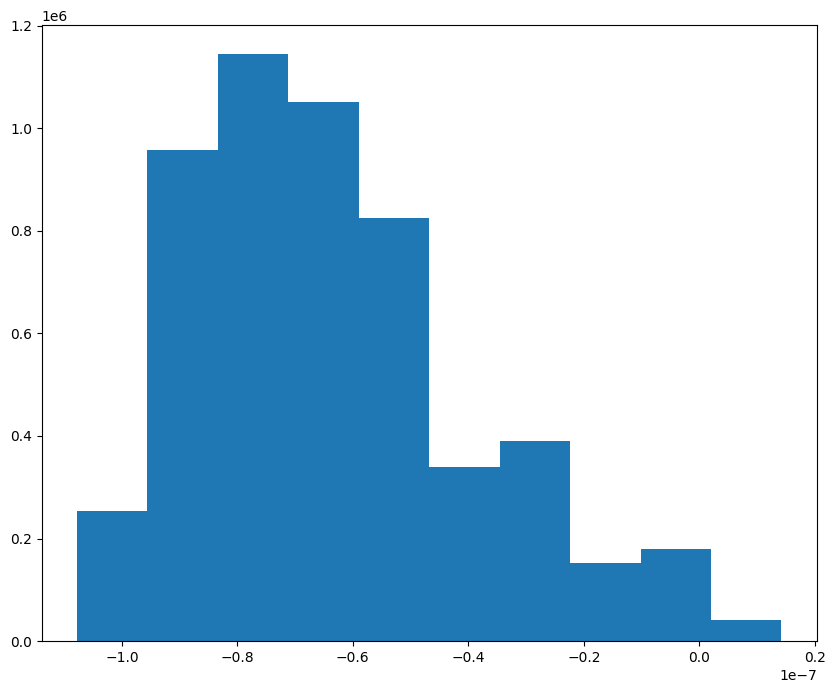

In [11]:
plt.hist(data.flatten())

In [12]:
#dobbiamo fare uno scaling per metterli tra 0 e 1: (D-min)/range
norm = (data-data.min(axis=(1,2),keepdims=True))/((data.max(axis=(1,2),keepdims=True))-(data.min(axis=(1,2),keepdims=True)))

In [13]:
norm.shape

(1302, 64, 64)

In [14]:
norm.max()

1.0

In [15]:
norm.min()

0.0

In [16]:
pos = np.load("spm/spm_struct_pos.npy") #qui ci sono le molecole
neg = np.load("spm/spm_struct_neg.npy") #qui ci sono non molecole

In [17]:
pos.shape, neg.shape

((500, 3), (500, 3))

In [18]:
pos[0] #mi dice immagine e posizione

array([30, 25, 51])

In [19]:
pos.max(axis=0) #l'immagine è il terzo numero

array([  62,   62, 1300])

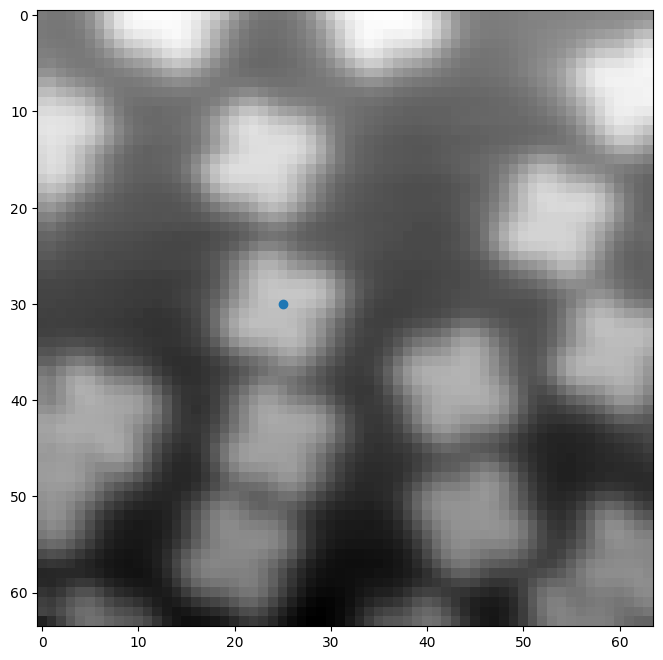

In [20]:
plt.imshow(norm[pos[0][2]])
plt.plot(pos[0][1],pos[0][0],'o')

In [21]:
#adesso creo delle immagini con solo molecola: dette annotazioni
#e delle immagini con solo altro
#guardando la molecola capisco che l'annotazione può essere fatta di 20x20
wid = 10
stmp_pos = []
for ii in range(pos.shape[0]):
  trow, tcol, tind = pos[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid): #voglio assicurarmi di non essere al limite dell'immagine
    stmp_pos.append(norm[tind,trow-wid:trow+wid,tcol-wid:tcol+wid])

stmp_pos = np.array(stmp_pos)

In [22]:
stmp_pos.shape

(389, 20, 20)

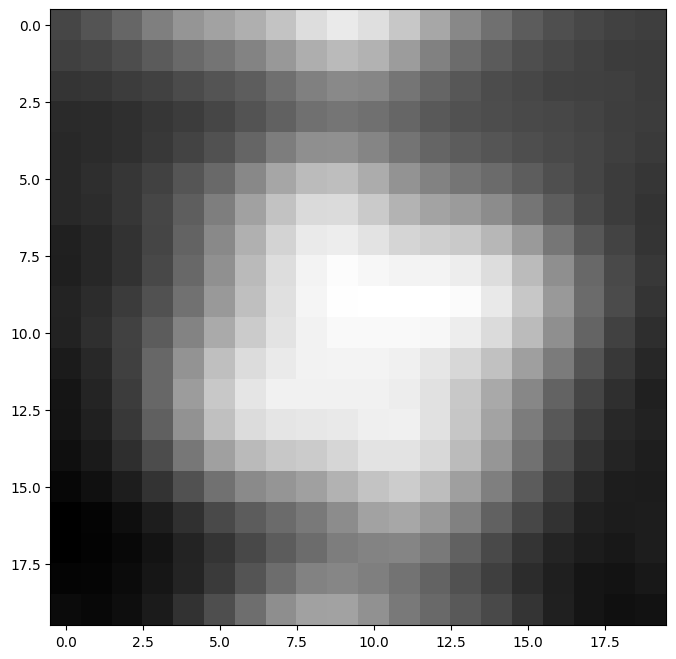

In [23]:
plt.imshow(stmp_pos[0])

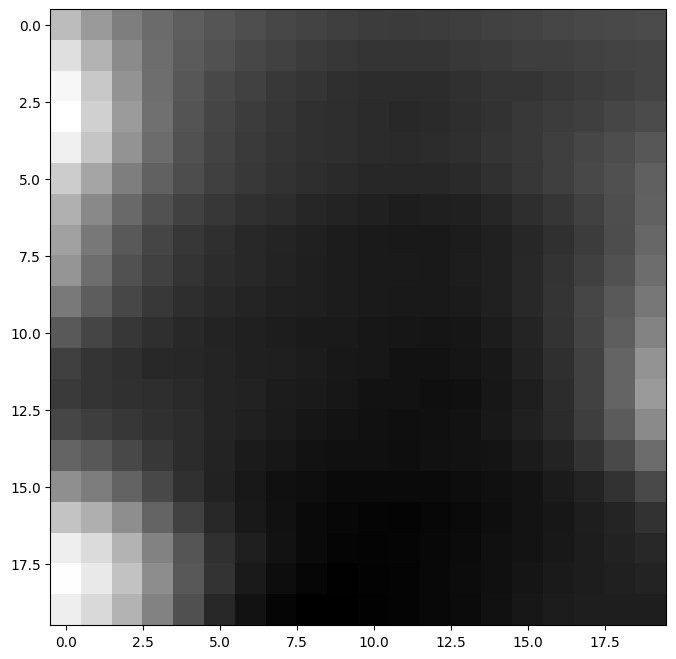

In [24]:
wid = 10
stmp_neg = []
for ii in range(neg.shape[0]):
  trow, tcol, tind = neg[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid): #voglio assicurarmi di non essere al limite dell'immagine
    stmp_neg.append(norm[tind,trow-wid:trow+wid,tcol-wid:tcol+wid])

stmp_neg = np.array(stmp_neg)
plt.imshow(stmp_neg[0])

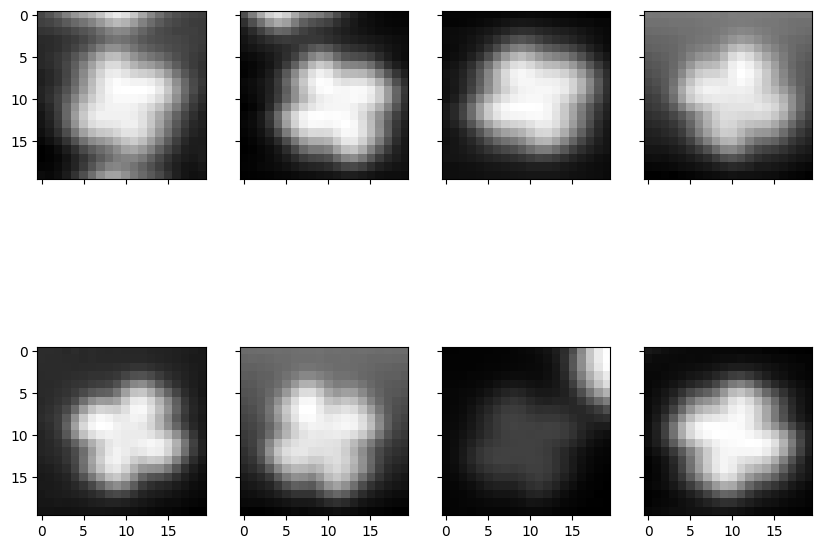

In [25]:
fig,ax=plt.subplots(2,4,sharex=True,sharey=True) #creo gli assi solo all'esterno
for ii in range(8):
  ax[ii//4,ii%4].imshow(stmp_pos[ii]) #questo serve a selezionare gli indici giusti

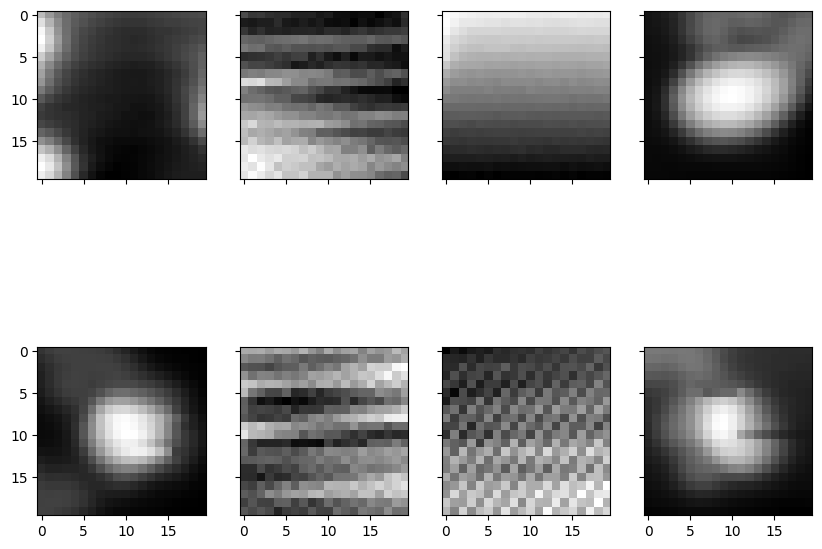

In [26]:
fig,ax=plt.subplots(2,4,sharex=True,sharey=True) #creo gli assi solo all'esterno
for ii in range(8):
  ax[ii//4,ii%4].imshow(stmp_neg[ii]) #questo serve a selezionare gli indici giusti

In [27]:
feat = np.concatenate((stmp_neg,stmp_pos),axis=0)
targ = np.concatenate((np.zeros(stmp_neg.shape[0]),np.ones(stmp_pos.shape[0])))

In [28]:
feat_tr,feat_test,targ_tr,targ_test=train_test_split(feat,targ,random_state=302) #devo fare shuffle perché erano ordinati, ma è default
#il default test size è 0.25

In [29]:
#la cnn si aspetta un rgb mentre noi abbiamo un canale solo
feat_tr = np.expand_dims(feat_tr,axis=3)
feat_test = np.expand_dims(feat_test,axis=3)
feat_tr.shape

(655, 20, 20, 1)

#creiamo la NN
- conv2d 16 neurons
- maxpool2d 2x2
- conv2d 32 neurons (anche avessimo tutti e 3 i canali lo faremmo 2d)
- maxpool2d 2x2
- flatten
- dense 64 neurons
- dense 2 neurons

In [30]:
keras.layers.Conv2D?

In [31]:
#padding tiene la dimensione dell'immagine: non toglie i bordi
#kernel_size è la dimensione della forma da guardare 
#regularizer bo
layer1 = keras.layers.Conv2D(16,kernel_size=(5,5),padding="same",activation="relu",
                             input_shape=(2*wid,2*wid,1),kernel_regularizer=keras.regularizers.l2(0.001))
layer2 = keras.layers.MaxPool2D(2)
layer3 = keras.layers.Conv2D(32,kernel_size=(5,5),padding="same",activation="relu",
                             kernel_regularizer=keras.regularizers.l2(0.001))
layer4 = keras.layers.MaxPool2D(2)
layer5 = keras.layers.Flatten()
layer6 = keras.layers.Dense(64,activation="relu",kernel_regularizer=keras.regularizers.l2(0.001))
#non avrebbe senso mettere una sigmoid perché prima non posso avere valori negativi
layer7 = keras.layers.Dense(2,activation="softmax") #questa activation si presta ad output binari


layers = [layer1,layer2,layer3,layer4,layer5,layer6,layer7]
model = keras.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                5

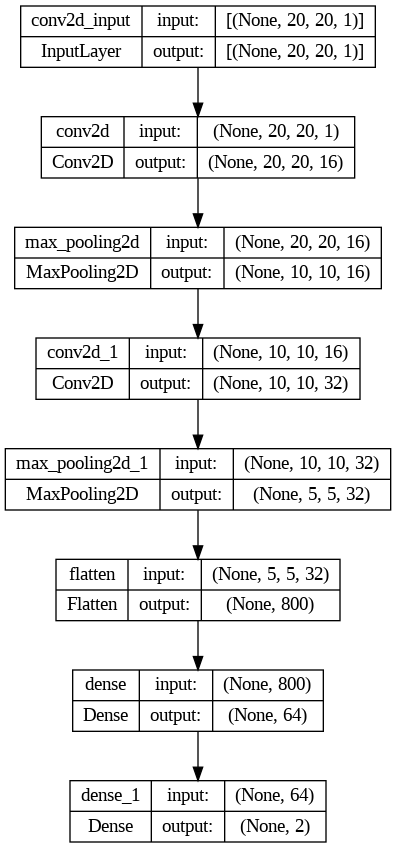

In [32]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics="accuracy") 
#qui ci serve una loss categorica

In [34]:
history = model.fit(feat_tr,targ_tr,epochs=50,
                    batch_size=50,validation_split=0.1) 
#il batch divide il train in pezzi più piccoli e poi si fa la media per il risultato, diminuisce l'overfitting
#la cross validation mi permette di fare una sorta di test set direttamente

Epoch 1/50
12/12 [==============================] - 10s 39ms/step - loss: 0.7268 - accuracy: 0.7216 - val_loss: 0.5767 - val_accuracy: 0.8939
Epoch 2/50
12/12 [==============================] - 0s 9ms/step - loss: 0.4974 - accuracy: 0.9117 - val_loss: 0.3580 - val_accuracy: 0.8939
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.3919 - accuracy: 0.9066 - val_loss: 0.3570 - val_accuracy: 0.8788
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.3152 - accuracy: 0.9236 - val_loss: 0.3204 - val_accuracy: 0.8788
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2786 - accuracy: 0.9355 - val_loss: 0.2934 - val_accuracy: 0.8788
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2454 - accuracy: 0.9525 - val_loss: 0.2593 - val_accuracy: 0.9091
Epoch 7/50
12/12 [==============================] - 0s 8ms/step - loss: 0.2190 - accuracy: 0.9525 - val_loss: 0.2378 - val_accuracy: 0.9394
Epoch 8/50
12/12 [

In [35]:
history.history["val_accuracy"]

[0.8939393758773804,
 0.8939393758773804,
 0.8787878751754761,
 0.8787878751754761,
 0.8787878751754761,
 0.9090909361839294,
 0.939393937587738,
 0.939393937587738,
 0.9242424368858337,
 0.9545454382896423,
 0.9696969985961914,
 0.939393937587738,
 0.9696969985961914,
 0.939393937587738,
 0.939393937587738,
 0.9545454382896423,
 0.939393937587738,
 0.939393937587738,
 0.9696969985961914,
 0.9545454382896423,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9545454382896423,
 0.9848484992980957,
 0.9848484992980957,
 0.9696969985961914,
 0.9696969985961914,
 0.9545454382896423,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9545454382896423,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9545454382896423,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9848484992980957,
 0.939393937587738,
 0.9545454382896423,


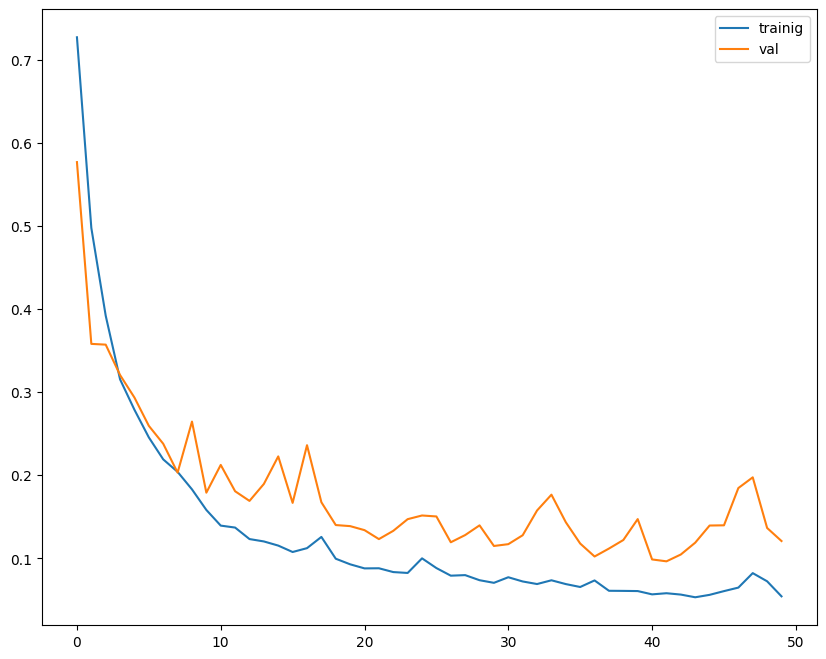

In [36]:
plt.plot(history.history["loss"],label="trainig")
plt.plot(history.history["val_loss"],label="val")
plt.legend()

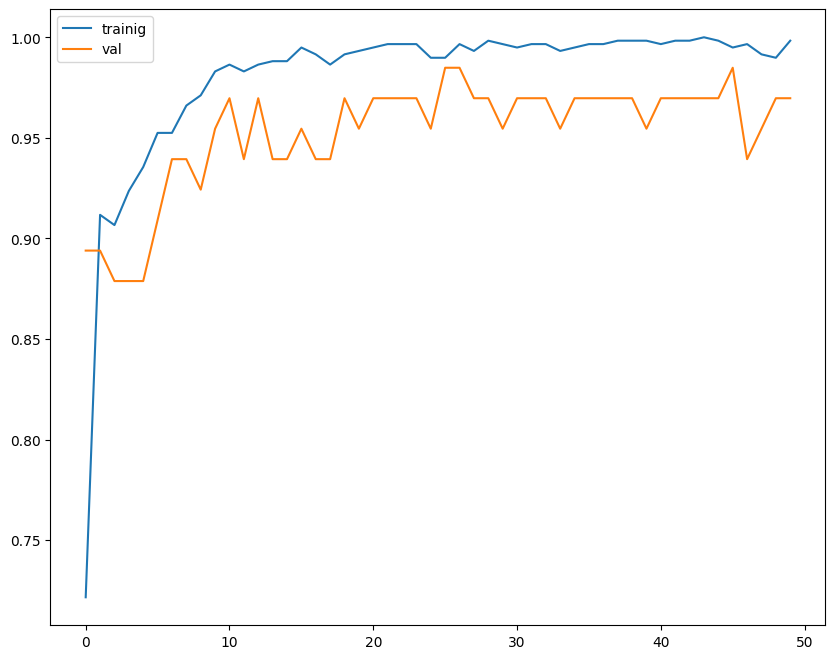

In [37]:
plt.plot(history.history["accuracy"],label="trainig")
plt.plot(history.history["val_accuracy"],label="val")
plt.legend()

In [38]:
loss_tr,acc_tr = model.evaluate(feat_tr,targ_tr)
loss_test,acc_test = model.evaluate(feat_test,targ_test)
loss_tr,acc_tr,loss_test,acc_test #qui vedo che funziona con i pezzi piccoli

7/7 [==============================] - 0s 12ms/step - loss: 0.0877 - accuracy: 0.9909


(0.05796051770448685,
 0.9969465732574463,
 0.08770016580820084,
 0.990867555141449)

In [39]:
#adesso vogliamo lavorare sulle immagini complete, troveremo una heatmap della confidenza
#di dove si trova la molecola
pos[0]

array([30, 25, 51])

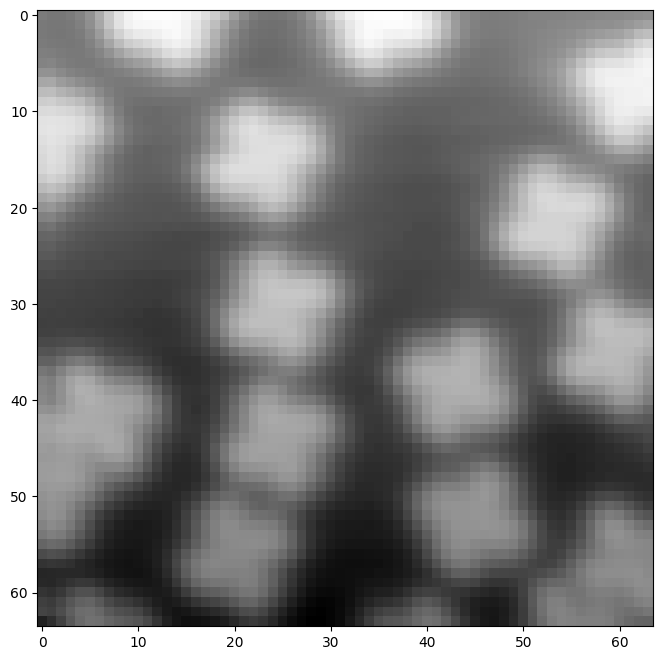

In [40]:
plt.imshow(norm[51])

In [41]:
img = norm[51].copy() #se non mettessi copy starei facendo un puntatore e io non voglio rovinare l'immagine

In [44]:
nrow,ncol=img.shape
stamps=np.zeros(((nrow-wid*2)*(ncol-wid*2),2*wid,2*wid)) 
#so quanto è grande, sono i punti dove posso mettere i centri, per ognuno di questi faccio un 20x20
stamps.shape

(1936, 20, 20)

In [45]:
kk = 0
for ii in range(wid,nrow-wid):
  for jj in range(wid,ncol-wid):
    stamps[kk] = img[ii-wid:ii+wid,jj-wid:jj+wid]
    kk+=1

feat_stmp=np.expand_dims(stamps,axis=3)

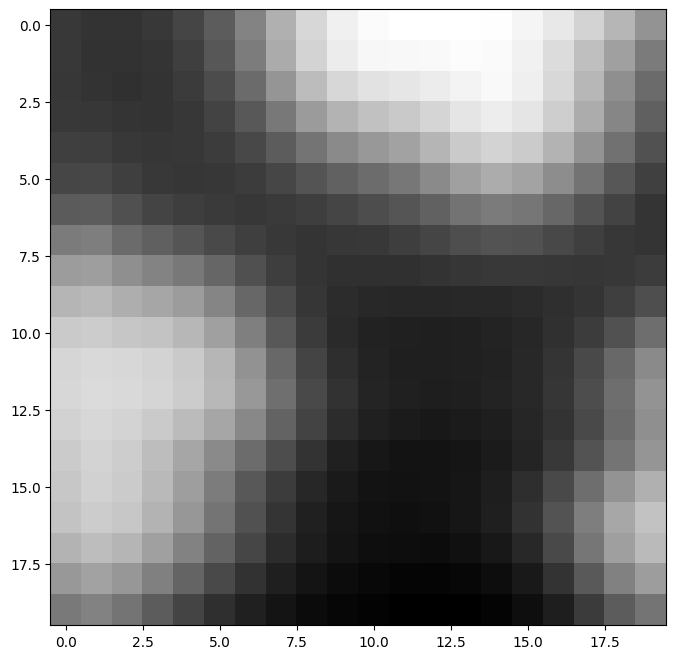

In [46]:
plt.imshow(feat_stmp[0]) #è l'angolo in alto di quella sopra

In [47]:
pred = model.predict(feat_stmp)

61/61 [==============================] - 0s 3ms/step


In [48]:
pred.shape #ho passato 1936 immagini, il 2 è l'output dei due neuroni (classificazione binaria)

(1936, 2)

In [49]:
pred #vediamo che è sempre uno circa 1 e l'altro circa 0

array([[1.0000000e+00, 3.0118169e-10],
       [1.0000000e+00, 4.8078024e-11],
       [1.0000000e+00, 1.1157489e-11],
       ...,
       [9.9999964e-01, 3.5187782e-07],
       [9.9999893e-01, 1.0365085e-06],
       [9.9997509e-01, 2.4950761e-05]], dtype=float32)

In [50]:
pimg = np.zeros(img.shape) #sappiamo già che suoi bordi vorremo 0
pimg[wid:nrow-wid,wid:ncol-wid] = pred[:,1].reshape(nrow-2*wid,ncol-2*wid)

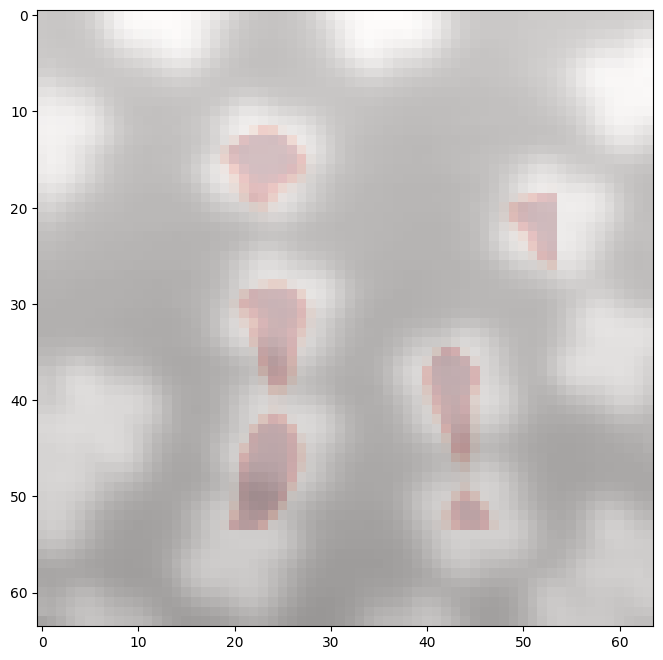

In [51]:
plt.imshow(img,alpha=0.5)
plt.imshow(pimg,alpha=0.2,cmap="Reds") #la predizione è andata bene, vedo il limite dei bordi

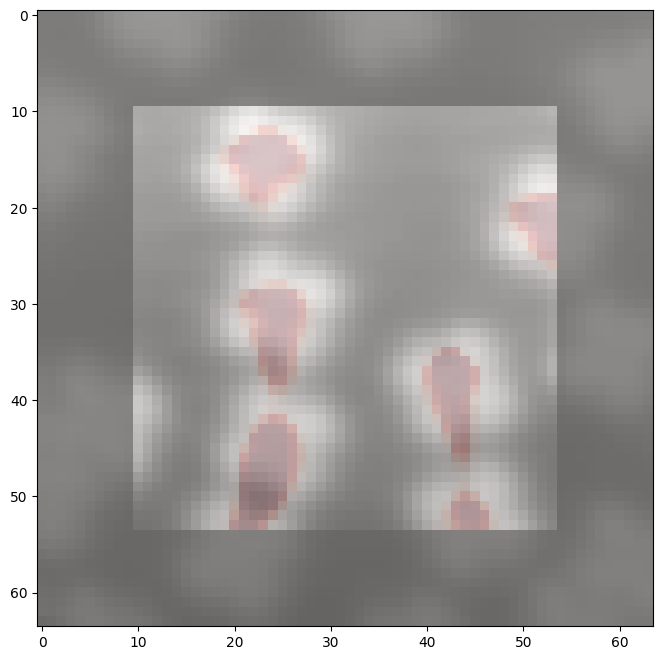

In [52]:
plt.imshow(img, alpha=0.5)
actualimg = img.copy()
actualimg[:wid,:] = 0
actualimg[-wid:,:] = 0
actualimg[:,:wid] = 0
actualimg[:,-wid:] = 0
plt.imshow(actualimg, alpha=0.5)
plt.imshow(pimg, cmap="Reds", alpha=0.2)

In [53]:
#posso vedere i pesi
model.layers[0].weights[0]

<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 16) dtype=float32, numpy=
array([[[[ 0.04030861,  0.06004408,  0.04076919,  0.05047496,
           0.07937083,  0.01166117, -0.05368169, -0.02302765,
           0.06951741,  0.02873362, -0.02247556, -0.09563349,
          -0.01495068,  0.11837996,  0.01919713,  0.06441958]],

        [[ 0.08109403,  0.06248745, -0.07370752,  0.02554717,
          -0.04749846, -0.08959496, -0.06003243,  0.02495542,
           0.02378233,  0.02548573, -0.04650037,  0.04861245,
           0.07235742,  0.0598161 ,  0.08112556,  0.02743051]],

        [[ 0.04975962,  0.14856958,  0.10131942,  0.02139106,
          -0.04208724, -0.05573844,  0.07705911, -0.03732236,
           0.11865009, -0.06843359,  0.04119125,  0.13524765,
           0.1445542 , -0.0685769 , -0.10561959,  0.08197233]],

        [[ 0.00266764,  0.06059309, -0.06968319,  0.0728865 ,
           0.09152247, -0.01533568,  0.13746217, -0.01226563,
          -0.07668018,  0.02520817,  0.03826533, -

In [ ]:
#questi sono praticamente le forme che ho imparato a riconoscere, a volte si capiscono
#da questi poi potrei le feature map dei vari layer
#dal layer dense posso vedere cosa arriva ai suoi 64 neuroni
#dovrei trovare un pattern differente fra pos e neg

In [ ]:
#abbiamo usato dei regularizer, questi impediscono che dei neuroni prendano eccessivo peso
#dovuto all'exploding gradient